可以看作XGboost的优化，适于处理大规模数据集，支持数据集和类别特征

In [1]:
import numpy as np 
import pandas as pd

## 绘图函数库
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from lightgbm.sklearn import LGBMClassifier

参数：
n_estimators
num_leaves参数：控制复杂度,每颗数的叶子数目
max_depth:或许作用不大
learning_rate:默认0.3
num_leaves:每棵树最大叶节点数量，默认32
subsample：默认1，一般设为0.8，控制每棵树随机采样的列数的占比
reg_alpha:l1正则 默认0
reg_lambda:l2正则 默认0
min_gain_to_split：最小分叉，控制过拟合
boosting_type：
    'gbdt', traditional Gradient Boosting Decision Tree.
 |          'dart', Dropouts meet Multiple Additive Regression Trees.
 |          'goss', Gradient-based One-Side Sampling.
 |          'rf', Random Forest.

可以利用lightGBM进行特征选择，属于嵌入式方法，调用接口clf.feature_importances_

In [11]:
df = pd.read_csv('./high_diamond_ranked_10min.csv')
y = df.blueWins
y.value_counts()
# 均衡样本

0    4949
1    4930
Name: blueWins, dtype: int64

In [12]:
drop_cols = ['gameId','blueWins']
x = df.drop(drop_cols, axis=1)

In [13]:
x.describe()
## 根据上面的描述，我们可以去除一些重复变量，比如只要知道蓝队是否拿到一血，我们就知道红队有没有拿到，可以去除红队的相关冗余数据。

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [14]:
drop_cols = ['redFirstBlood','redKills','redDeaths'
             ,'redGoldDiff','redExperienceDiff', 'blueCSPerMin',
            'blueGoldPerMin','redCSPerMin','redGoldPerMin']
x.drop(drop_cols, axis=1, inplace=True)

In [16]:
data

,blueWins,Features,Values
0,0,blueTowersDestroyed,-0.210428
1,0,blueTowersDestroyed,-0.210428
2,0,blueTowersDestroyed,-0.210428
3,0,blueTowersDestroyed,-0.210428
4,0,blueTowersDestroyed,-0.210428
...,...,...,...
88906,1,redWardsPlaced,1.280354
88907,1,redWardsPlaced,-0.561723
88908,0,redWardsPlaced,-0.453365
88909,0,redWardsPlaced,2.363929


In [19]:
test=(x - x.mean()) / x.std()
pd.concat([y, test.iloc[:, 0:9]], axis=1)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds
0,0,0.316980,-0.379256,0.990379,0.935254,-0.046924,1.071441,-0.879186,-0.753188,-0.481108
1,0,-0.570963,-0.839026,-1.009612,-0.393196,-0.387777,-0.404748,-0.879186,-0.753188,-0.481108
2,0,-0.404474,-1.298797,-1.009612,0.271029,1.657340,-0.650779,0.719467,1.327556,-0.481108
3,0,1.149426,-0.839026,-1.009612,-0.725309,-0.387777,-0.404748,0.719467,-0.753188,2.078325
4,0,2.925312,0.540285,-1.009612,-0.061084,-0.046924,-0.158716,-0.879186,-0.753188,-0.481108
...,...,...,...,...,...,...,...,...,...,...
9874,1,-0.293481,-0.379256,0.990379,0.271029,-0.728629,-0.404748,0.719467,1.327556,-0.481108
9875,1,1.759887,-1.298797,-1.009612,-0.061084,-0.728629,0.333347,0.719467,1.327556,-0.481108
9876,0,0.039497,-0.839026,-1.009612,-0.061084,0.293929,-0.404748,-0.879186,-0.753188,-0.481108
9877,0,-0.459970,0.540285,0.990379,-1.389534,-1.069482,-0.896811,0.719467,1.327556,-0.481108


In [21]:
data.tail(10)

,blueWins,Features,Values
88901,0,redWardsPlaced,-0.507544
88902,1,redWardsPlaced,-0.615901
88903,0,redWardsPlaced,-0.290829
88904,1,redWardsPlaced,2.038857
88905,1,redWardsPlaced,-0.345008
88906,1,redWardsPlaced,1.280354
88907,1,redWardsPlaced,-0.561723
88908,0,redWardsPlaced,-0.453365
88909,0,redWardsPlaced,2.363929
88910,1,redWardsPlaced,-0.724259


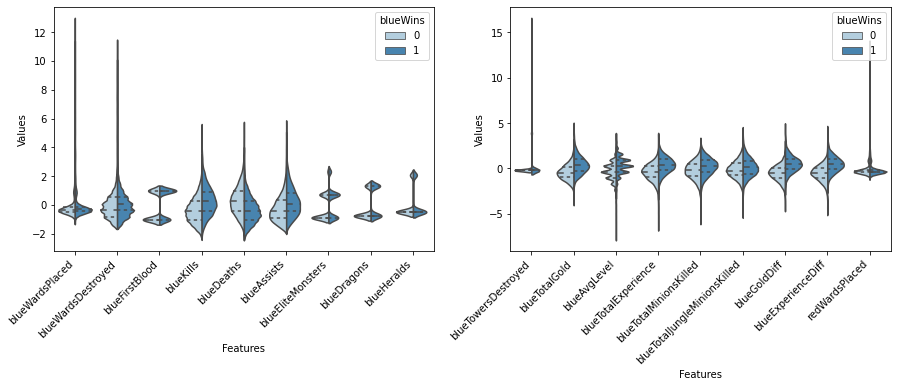

In [15]:
data = x
data_std = (data - data.mean()) / data.std()  #正规化
data = pd.concat([y, data_std.iloc[:, 0:9]], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

fig, ax = plt.subplots(1,2,figsize=(15,5))

# 绘制小提琴图
sns.violinplot(x='Features', y='Values', hue='blueWins', data=data, split=True,
               inner='quart', ax=ax[0], palette='Blues')
fig.autofmt_xdate(rotation=45)

data = x
data_std = (data - data.mean()) / data.std()
data = pd.concat([y, data_std.iloc[:, 9:18]], axis=1)
data = pd.melt(data, id_vars='blueWins', var_name='Features', value_name='Values')

# 绘制小提琴图
sns.violinplot(x='Features', y='Values', hue='blueWins', 
               data=data, split=True, inner='quart', ax=ax[1], palette='Blues')
fig.autofmt_xdate(rotation=45)

plt.show()

从图中我们可以看出：

击杀英雄数量越多更容易赢，死亡数量越多越容易输（bluekills与bluedeaths左右的区别）。
助攻数量与击杀英雄数量形成的图形状类似，说明他们对游戏结果的影响差不多。
一血的取得情况与获胜有正相关，但是相关性不如击杀英雄数量明显。
经济差与经验差对于游戏胜负的影响较小。
击杀野怪数量对游戏胜负的影响并不大。

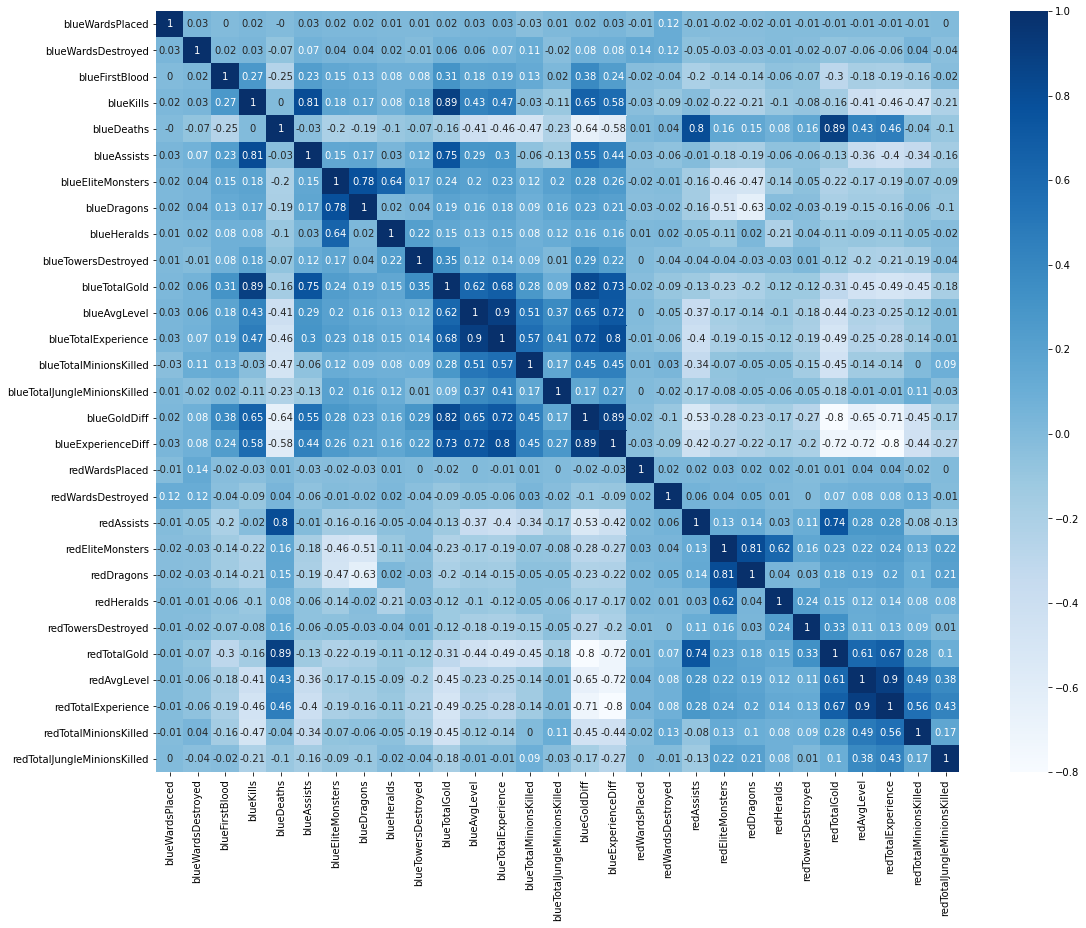

In [22]:
plt.figure(figsize=(18,14))
sns.heatmap(round(x.corr(),2), cmap='Blues', annot=True)
plt.show()
# 同时我们画出各个特征之间的相关性热力图，颜色越深代表特征之间相关性越强，我们剔除那些相关性较强的冗余特征。

In [ ]:
drop_cols = ['blueWardsPlaced','blueWardsDestroyed',
           'redWardsPlaced','redWardsDestroyed']
x.drop(drop_cols, axis=1, inplace=True)
# 眼位与胜负关系不大

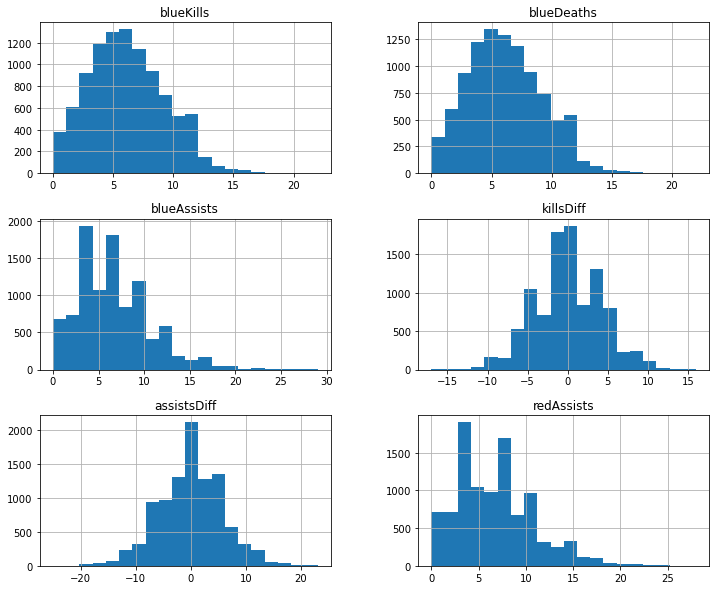

In [37]:
x['killsDiff'] = x['blueKills'] - x['blueDeaths']
x['assistsDiff'] = x['blueAssists'] - x['redAssists']

x[['blueKills','blueDeaths','blueAssists','killsDiff','assistsDiff','redAssists']].hist(figsize=(12,10), bins=20)
plt.show()

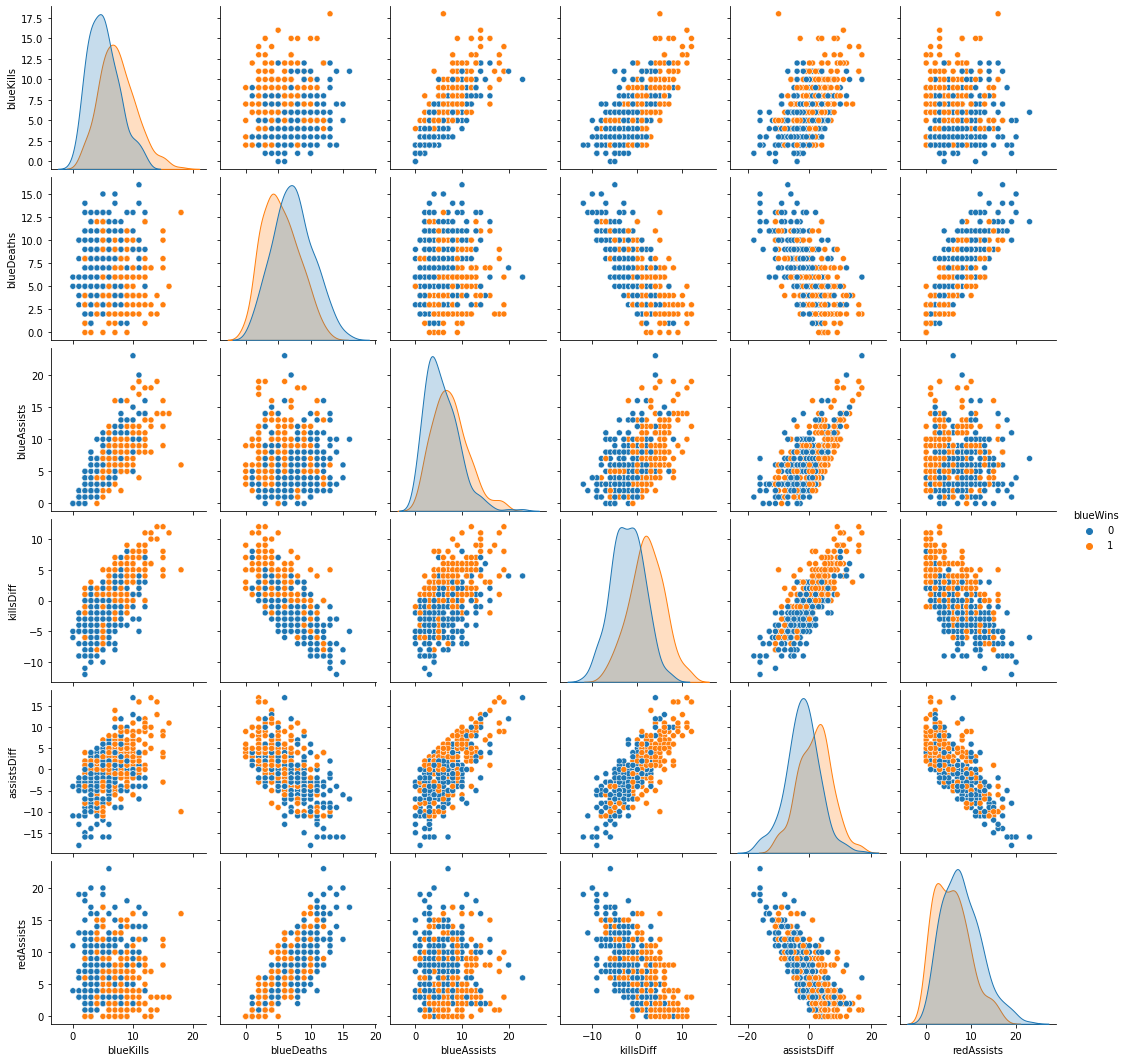

In [39]:
data = pd.concat([y, x], axis=1).sample(500)

sns.pairplot(data, vars=['blueKills','blueDeaths','blueAssists','killsDiff','assistsDiff','redAssists'], 
             hue='blueWins')

plt.show()

eliteDiff
-2    0.286301
-1    0.368772
 0    0.500683
 1    0.632093
 2    0.735211
Name: blueWins, dtype: float64
dragonsDiff
-1    0.374173
 0    0.500000
 1    0.640940
Name: blueWins, dtype: float64
heraldsDiff
-1    0.387729
 0    0.498680
 1    0.595046
Name: blueWins, dtype: float64


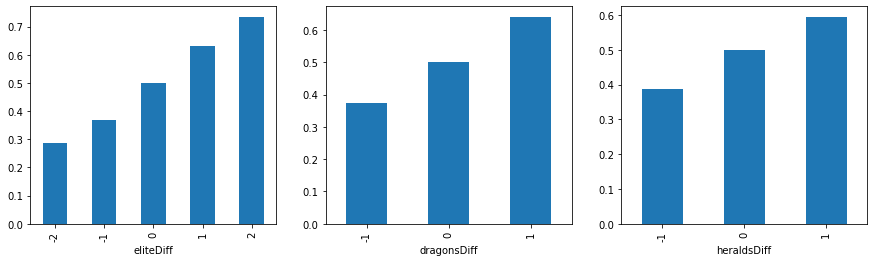

In [40]:
x['dragonsDiff'] = x['blueDragons'] - x['redDragons']
x['heraldsDiff'] = x['blueHeralds'] - x['redHeralds']
x['eliteDiff'] = x['blueEliteMonsters'] - x['redEliteMonsters']

data = pd.concat([y, x], axis=1)

eliteGroup = data.groupby(['eliteDiff'])['blueWins'].mean()
dragonGroup = data.groupby(['dragonsDiff'])['blueWins'].mean()
heraldGroup = data.groupby(['heraldsDiff'])['blueWins'].mean()

fig, ax = plt.subplots(1,3, figsize=(15,4))

eliteGroup.plot(kind='bar', ax=ax[0])
dragonGroup.plot(kind='bar', ax=ax[1])
heraldGroup.plot(kind='bar', ax=ax[2])

print(eliteGroup)
print(dragonGroup)
print(heraldGroup)

plt.show()

我们构造了两队之间是否拿到龙、是否拿到峡谷先锋、击杀大型野怪的数量差值，发现在游戏的前期拿到龙比拿到峡谷先锋更容易获得胜利。拿到大型野怪的数量和胜率也存在着强相关。